In [1]:
library(tidyverse)
library(tidymodels)
library(RColorBrewer)
library(cowplot)
library(GGally)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
cleveland <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", col_names = FALSE)
hungarian <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data", col_names = FALSE)
switzerland <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.switzerland.data", col_names = FALSE)
va <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.va.data", col_names = FALSE)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X5, X6, X7, X8, X9, X11, X12, X13
dbl (5): X1, X2, X3, X10, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 123 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X6, X7, X8, X9, X10, X11, X12, X13
dbl (5): X1, X2, X3, X5, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or 

In [3]:
#Adding an origin category for each row
cleveland_data <- mutate(cleveland, Origin = "cleveland")
hungarian_data <- mutate(hungarian, Origin = "hungarian")
switzerland_data <- mutate(switzerland, Origin = "switzerland")
va_data <- mutate(va, Origin = "longbeach")

#Combining the data into one mega data set
mega <- rbind(cleveland_data, hungarian_data, switzerland_data, va_data)

#Adding names to each column
column_names = c("age", 
                 "sex", 
                 "X3", 
                 "X4", 
                 "X5", 
                 "X6", 
                 "X7", 
                 "X8", 
                 "exercise_induced_angina", 
                 "st_depression", 
                 "st_segment_slope", 
                 "X12", 
                 "thalassemia", 
                 "presence_of_cvd", 
                 "origin"
                )
colnames(mega) <- column_names

#Selecting the columns of interest
mega_data <- mega |> 
                select(age, sex, exercise_induced_angina, st_depression, st_segment_slope, thalassemia, presence_of_cvd, origin)

#Removing all rows that with at least one missing variable in any column.
tidy_data <- mega_data |> 
                filter(exercise_induced_angina != "?" & st_depression != "?" & st_segment_slope != "?" & thalassemia != "?")

#Combining heart severity levels 1 to 4 into one measurement and converting variables in presence_of_cvd into "Yes" or "No"
severity_1_to_4 <- tidy_data |> 
                    filter(presence_of_cvd != 0) |> 
                    mutate(presence_of_cvd = "Yes")

tidy_data <- tidy_data |> 
                filter(presence_of_cvd == 0) |> 
                mutate(presence_of_cvd = "No") |> 
                rbind(severity_1_to_4)

# Converting variables into proper data types
tidy_data <- tidy_data |> 
                mutate(presence_of_cvd = as.factor(presence_of_cvd),
                       exercise_induced_angina = as.double(exercise_induced_angina),
                       st_depression = as.double(st_depression),
                       st_segment_slope = as.double(st_segment_slope),
                       thalassemia = as.double(thalassemia)
                       )

In [4]:
head(tidy_data)
nrow(tidy_data)

age,sex,exercise_induced_angina,st_depression,st_segment_slope,thalassemia,presence_of_cvd,origin
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
63,1,0,2.3,3,6,No,cleveland
37,1,0,3.5,3,3,No,cleveland
41,0,0,1.4,1,3,No,cleveland
56,1,0,0.8,1,3,No,cleveland
57,0,1,0.6,1,3,No,cleveland
57,1,0,0.4,2,6,No,cleveland


[1] 385

In [5]:
set.seed(2)
split_data <- initial_split(tidy_data, prop = 0.75, strata = presence_of_cvd)
cvd_training <- training(split_data)
cvd_testing <- testing(split_data)

In [6]:
# creating recipes for each combination of age + sex + x predictor
cvd_recipe_eia <- recipe(cvd_training, presence_of_cvd ~ age + sex + exercise_induced_angina, data = cvd_training) |> 
                # step_scale(age) |> 
                # step_center(age)
                step_scale(all_predictors()) |>
                step_center(all_predictors())

cvd_recipe_std <- recipe(cvd_training, presence_of_cvd ~ age + sex + st_depression, data = cvd_training) |> 
                # step_scale(age, st_depression) |> 
                # step_center(age, st_depression)
                step_scale(all_predictors()) |>
                step_center(all_predictors())

cvd_recipe_stss <- recipe(cvd_training, presence_of_cvd ~ age + sex + st_segment_slope, data = cvd_training) |> 
                # step_scale(age) |> 
                # step_center(age)
                step_scale(all_predictors()) |>
                step_center(all_predictors())

cvd_recipe_tha <- recipe(cvd_training, presence_of_cvd ~ age + sex + thalassemia, data = cvd_training) |> 
                # step_scale(age) |> 
                # step_center(age)
                step_scale(all_predictors()) |>
                step_center(all_predictors())

In [7]:
knn_tune_spec <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) |> 
                set_engine('kknn') |> 
                set_mode('classification')

kvals <- tibble(neighbors = 1:20)
cvd_vfold <- vfold_cv(cvd_training, v = 5, strata = presence_of_cvd)

In [8]:
# getting accuracy tibble for each recipe
eia_acc <- workflow() |> 
            add_recipe(cvd_recipe_eia) |> 
            add_model(knn_tune_spec) |> 
            tune_grid(resamples = cvd_vfold, grid = kvals) |>
            collect_metrics() |> 
            filter(.metric == 'accuracy')

std_acc <- workflow() |> 
            add_recipe(cvd_recipe_std) |> 
            add_model(knn_tune_spec) |> 
            tune_grid(resamples = cvd_vfold, grid = kvals) |>
            collect_metrics() |> 
            filter(.metric == 'accuracy')

stss_acc <- workflow() |> 
            add_recipe(cvd_recipe_stss) |> 
            add_model(knn_tune_spec) |> 
            tune_grid(resamples = cvd_vfold, grid = kvals) |>
            collect_metrics() |> 
            filter(.metric == 'accuracy')

tha_acc <- workflow() |> 
            add_recipe(cvd_recipe_tha) |> 
            add_model(knn_tune_spec) |> 
            tune_grid(resamples = cvd_vfold, grid = kvals) |>
            collect_metrics() |> 
            filter(.metric == 'accuracy')

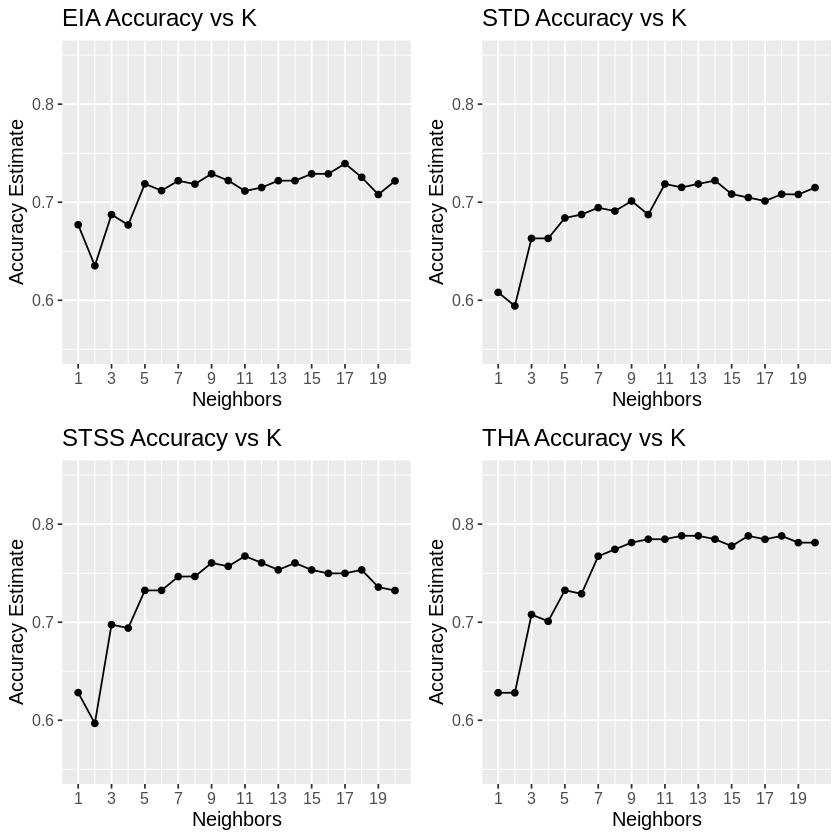

In [9]:
# plotting accuracy vs k for each recipe
eia_acc_vs_k <- ggplot(eia_acc, aes(x = neighbors, y = mean)) +
                    geom_point() +
                    geom_line() +
                    labs(x = "Neighbors", y = "Accuracy Estimate") + 
                    ggtitle('EIA Accuracy vs K') +
                    ylim(0.55, 0.85) +
                    scale_x_continuous(breaks = seq(1, 20, 2)) +
                    theme(text = element_text(size = 12))

std_acc_vs_k <- ggplot(std_acc, aes(x = neighbors, y = mean)) +
                    geom_point() +
                    geom_line() +
                    labs(x = "Neighbors", y = "Accuracy Estimate") + 
                    ggtitle('STD Accuracy vs K') +
                    ylim(0.55, 0.85) +
                    scale_x_continuous(breaks = seq(1, 20, 2)) +
                    theme(text = element_text(size = 12))

stss_acc_vs_k <- ggplot(stss_acc, aes(x = neighbors, y = mean)) +
                    geom_point() +
                    geom_line() +
                    labs(x = "Neighbors", y = "Accuracy Estimate") + 
                    ggtitle('STSS Accuracy vs K') +
                    ylim(0.55, 0.85) +
                    scale_x_continuous(breaks = seq(1, 20, 2)) +
                    theme(text = element_text(size = 12))

tha_acc_vs_k <- ggplot(tha_acc, aes(x = neighbors, y = mean)) +
                    geom_point() +
                    geom_line() +
                    labs(x = "Neighbors", y = "Accuracy Estimate") + 
                    ggtitle('THA Accuracy vs K') +
                    ylim(0.55, 0.85) +
                    scale_x_continuous(breaks = seq(1, 20, 2)) +
                    theme(text = element_text(size = 12))

plot_grid(eia_acc_vs_k, std_acc_vs_k, stss_acc_vs_k, tha_acc_vs_k)

In the above plot, it seems that a recipe with predictors `age`, `sex`, and `thalassemia` gives the highest classifier model accuracies, thus this recipe will be used. Additionally, a value of $k = 13$ is chosen because _high acc, changing by 1 doesnt change accuracy drastically, not too high/expensive, put into proper sentences_

In [10]:
knn_spec <- nearest_neighbor(weight_func = 'rectangular', neighbors = 13) |> 
                set_engine('kknn') |> 
                set_mode('classification')

cvd_tha_fit <- workflow() |> 
            add_recipe(cvd_recipe_tha) |> 
            add_model(knn_spec) |> 
            fit(data = cvd_training)
cvd_tha_predict <- predict(cvd_tha_fit, cvd_testing) |> 
                bind_cols(cvd_testing)

head(cvd_tha_predict)
tail(cvd_tha_predict)

.pred_class,age,sex,exercise_induced_angina,st_depression,st_segment_slope,thalassemia,presence_of_cvd,origin
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
No,56,0,0,1.3,2,3,No,cleveland
No,57,1,0,1.6,1,3,No,cleveland
No,48,0,0,0.2,1,3,No,cleveland
No,50,0,0,1.6,2,3,No,cleveland
No,44,1,1,0.4,1,3,No,cleveland
Yes,61,1,1,1.0,2,3,No,cleveland


.pred_class,age,sex,exercise_induced_angina,st_depression,st_segment_slope,thalassemia,presence_of_cvd,origin
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
Yes,62,1,1,1.6,1,7,Yes,longbeach
Yes,57,1,1,2.0,2,6,Yes,longbeach
Yes,64,0,1,1.0,2,7,Yes,longbeach
Yes,61,1,1,4.0,3,6,Yes,longbeach
Yes,53,1,1,2.0,2,7,Yes,longbeach
Yes,55,1,1,1.7,3,7,Yes,longbeach


In [11]:
cvd_tha_metrics <- cvd_tha_predict |>
                    metrics(truth = presence_of_cvd, estimate = .pred_class) |>
                    filter(.metric == 'accuracy')

cvd_tha_confusion <- cvd_tha_predict |>
                        conf_mat(truth = presence_of_cvd, estimate = .pred_class)

cvd_tha_metrics
cvd_tha_confusion

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7938144


          Truth
Prediction No Yes
       No  30   7
       Yes 13  47

In [79]:
age_grid <- seq(min(tidy_data$age),
                max(tidy_data$age),
                length.out = 45)

tha_grid <- seq(min(tidy_data$thalassemia),
                max(tidy_data$thalassemia),
                length.out = 45)

sex_grid <- seq(min(tidy_data$sex),
                max(tidy_data$sex),
                length.out = 45)

atgrid <- as_tibble(expand.grid(age = age_grid,
                                thalassemia = tha_grid,
                                sex = sex_grid))
nrow(atgrid)

[1] 91125

In [80]:
knnPredGrid <- predict(cvd_tha_fit, atgrid)

In [81]:
prediction_table <- bind_cols(knnPredGrid, atgrid)
# head(prediction_table)
# tail(prediction_table)

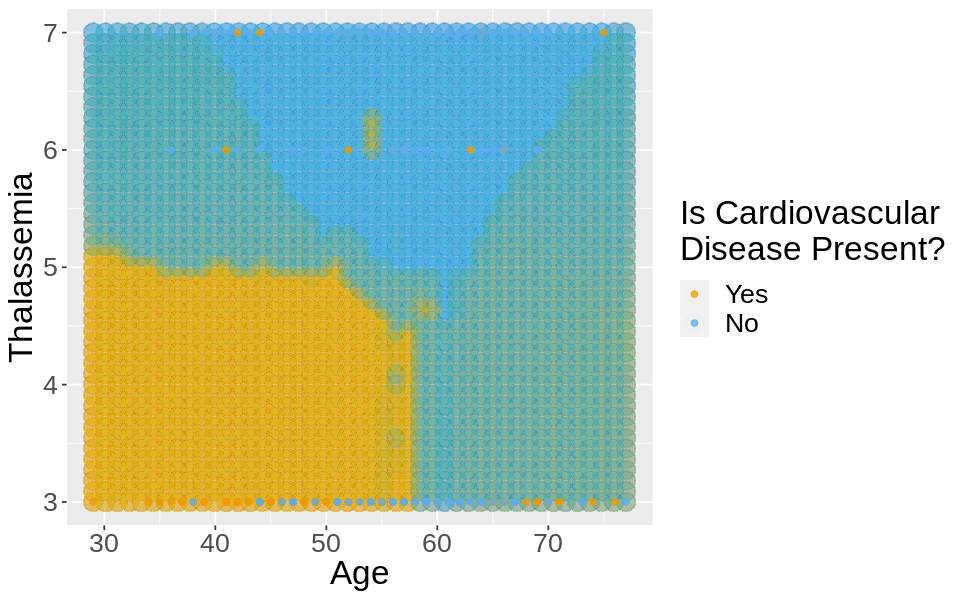

In [82]:
options(repr.plot.height = 5, repr.plot.width = 8)
cvd_plot <- ggplot() +
                geom_point(data = prediction_table,
                           mapping = aes(x = age, y = thalassemia, color = .pred_class),
                           alpha = 0.02,
                           size = 5) +
                geom_point(data = tidy_data,
                           mapping = aes(x = age, y = thalassemia, color = presence_of_cvd),
                           alpha = 0.75) +
                labs(color = 'Is Cardiovascular\nDisease Present?',
                     x = 'Age',
                     y = 'Thalassemia') +
                scale_color_manual(labels = c('Yes', 'No'),
                                   values = c('orange2', 'steelblue2')) +
                theme(text = element_text(size = 20))
cvd_plot

In [13]:
# cvd_pairs <- select(tidy_data, age:presence_of_cvd) |> 
#                 ggpairs()
# cvd_pairs

1. make recipe for each combination of age, sex, + remainder
2. cross val all recipes + tune k
3. find best k using graph
4. choose best recipe based on acc